*Author*: Jeyshinee Pyneeandee, March 2024 
###### (Based on code/05_Data Availability Plot.ipynb by Marianne) 
This is a script to display the data availability of ISIS Ionograms based on stations.

In [1]:
#Required imports 
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
# import pycountry
# import urllib
# import PIL

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import dates as mdates
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # Remove Setting with copy warning in pandas

In [2]:

def availabilityPlot(results_file,startDate,endDate,title,stationCode='all',cmap='winter_r'):
   #Transforming Year format by adding 19 in front. All metadata year read incorrectly by KERAS will have 20 added instead.
    results_file['Year'] = results_file['Year'].astype(str)
    my_year = results_file['Year']
    my_updated_year = []
    for year in my_year:
        if len(year) == 2:
            year = "19" + year
            my_updated_year.append(year)
        else:
            year = "20" + year + "0"
            my_updated_year.append(year)
    

    #Transforming day of year into Month-Day. All metadata day read incorrectly by KERAS will be equal to 365 instead.
    day_num = results_file['Day']
    final_date_format = []
    for year, day in zip(my_updated_year, day_num):
        if  day != 0 and day <= 365:
            day = str(day)
            convert_datetime = str(dt.strptime(year + "-" + day, "%Y-%j").strftime("%Y-%m-%d"))
            final_date_format.append(convert_datetime)

        else:
            year, day  = "2000", "365"
            convert_datetime = str(dt.strptime(year + "-" + day, "%Y-%j").strftime("%Y-%m-%d"))
            final_date_format.append(convert_datetime)

    results_file["Timestamp"] = final_date_format
    results_file["Year Updated"] = my_updated_year
    del final_date_format, my_updated_year
    results_file['Timestamp']=pd.to_datetime(results_file['Timestamp'], format="%Y-%m-%d")
    
    # Filter the data with the dates
    startDate=pd.to_datetime(startDate)
    endDate=pd.to_datetime(endDate)
    subset = results_file.loc[(results_file['Timestamp']>=startDate) & (results_file['Timestamp']<=endDate)]

    # Filter the data with the station code
    if (stationCode != None) & (stationCode != 'all') :
        subset = subset.loc[subset['Station_ID'].isin(stationCode)]
    
    subset.reset_index(inplace=True) 

    # Count number of times each stations appear in the document (number of measures per station)
    subset['Station_Frequency'] = subset.groupby('Station_Number')['Station_Number'].transform('count')
    
    # We are only interested in the days, not the hours so we normalize the dates
    subset['Timestamp']=subset['Timestamp'].dt.normalize()

    
    # For a smaller dataframe, we drop the duplicates
    subset.drop_duplicates(inplace=True)
    subset.sort_values('Station_Frequency', inplace=True, ascending=True)
    
    # Add dates Covered and Not covered by any station
    # Extract the covered dates and sort them
    covered = pd.DataFrame()
    covered['Timestamp'] = subset['Timestamp'].unique()
    if stationCode != None :
        covered['Days_with_data'] = np.repeat('Days with data',len(covered))
    else:
        covered['Days_with_data'] = np.repeat(0.5,len(covered))    
    covered.sort_values(by='Timestamp',inplace=True,ascending=True,ignore_index=True)
    
    # Create empty dataframe
    notcovered = pd.DataFrame(columns=['Timestamp','Days_without_data'])
    # One day measure
    oneday = datetime.timedelta(days=1)
    # For all dates covered
    for i in range(len(covered)-1):
        # Create temporary dataframe
        toadd = pd.DataFrame(columns=['Timestamp','Days_without_data'])
        # Calculate number of days between two dates covered
        interval = (covered['Timestamp'][i+1]-covered['Timestamp'][i])/np.timedelta64(1, 'D')
        # If there's more than one day between two consecutive dates
        if interval > 1. :
            # Add the dates between as not covered
            toadd['Timestamp'] = pd.date_range(covered['Timestamp'][i]+oneday,covered['Timestamp'][i+1]-oneday)
            if stationCode != None :
                toadd['Days_without_data'] = np.repeat('Days without data',len(toadd))
            else:
                toadd['Days_without_data'] = np.repeat(0,len(toadd))
            notcovered = pd.concat([notcovered,toadd],ignore_index=True)  
    
    # Create figure
    fig, ax = plt.subplots()
    fig.suptitle(title)
    # The padding of the figure, we need enough space for the title, colorbar and the station name on the left
    fig.subplots_adjust(top=0.93,bottom=0.2, left=0.3)
    
    # Plot the data availability
    ax.scatter(notcovered['Timestamp'],notcovered['Days_without_data'],marker='|',linewidth=0.7, color='grey')
    ax.scatter(covered['Timestamp'],covered['Days_with_data'],marker='|',linewidth=0.7, color='black')

    if stationCode != None :
        plot = ax.scatter(subset['Timestamp'],subset['Station_Location'],c=subset['Station_Frequency'],
                          cmap=cmap,marker='|',linewidth=0.7)
        # Add the colorbar
        cax=fig.add_axes([0.34, 0.067, 0.5, 0.03]) # Colorbar axe
        cbar = fig.colorbar(plot,cax=cax,orientation='horizontal')
        cbar.set_label('Number of ionograms between '+startDate.strftime('%Y-%m-%d')+' and '+endDate.strftime('%Y-%m-%d'))
        
        # Add flags
        # Create new dataframe
        stationName = pd.DataFrame()
        # Add the station name and the country for each station
        stationName['Station_Name'] = subset['Station_ID']
        stationName['Country'] = subset['Station_Location']
        # Drop the duplicates to only have each station one time
        stationName.drop_duplicates(inplace=True, ignore_index=True)

        # Add the flags to the plot
        # if len(notcovered)==0 :
        #     a = 1
        # else :
        #     a = 2
        # for i, c in enumerate(stationName['Country']):
        #     add_image(i+a, c, ax, startDate)
        
    else :
        ax.set_yticks([0,0.5])
        ax.set_yticklabels(['Days without data','Days with data'])
        ax.set_ylim(-0.15,0.65)
    
    # Add grid and adjust the x and y ticks
    ax.grid(which='major',axis='x',alpha=0.7,lw=0.7,ls='-')
    ax.grid(which='minor',axis='x',alpha=0.7,lw=0.5,ls='--')
    ax.tick_params(which='major',axis='x',labelrotation=90)
    ax.tick_params(which='major',axis='y', pad=26)
    
    # Add the text box for overall days covered
    date_only = subset['Timestamp']
    # The number of unique dates divided by the number of total days
    nbdays = int((endDate-startDate).days+1)
    per = len(date_only.unique()) / nbdays * 100
    text = '% of days with data : '+ "%.2f" % per +'%'
    box = dict(boxstyle='round,pad=0.5', alpha=0.5)
    fig.text(0.13, 0.075, text, va='bottom',bbox=box)
    
    # Custom x ticks
    interval = int((endDate-startDate)/np.timedelta64(1, 'W'))
                      
    # x ticks vary depending on the interval of time between the start and end dates
    if(interval<=6*4):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='W'),minor=False)
    elif(interval<=18*4):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='MS'),minor=False)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='SMS'),minor=True)
    elif(interval<=36*4):
        ax.set_xticks(pd.date_range(startDate,endDate,freq='MS'),minor=True)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='2MS'),minor=False)
    elif(interval<=60*4):
        xmajor = pd.date_range(startDate,endDate,freq='4MS')
        ax.set_xticks(xmajor, minor=False,)
        ax.set_xticklabels(xmajor.strftime('%Y-%m'), minor=False)
        ax.set_xticks(pd.date_range(startDate,endDate,freq='2MS'),minor=True)
    else:
        xmajor=pd.date_range(str(startDate.year)+'0701',str(endDate.year)+'0701',freq='6MS')
        ax.set_xticks(pd.date_range(startDate,endDate,freq='QS'),minor=True)
        ax.set_xticklabels(xmajor.strftime('%Y-%m'), minor=False)
        ax.set_xticks(xmajor,minor=False)
    
    #return(fig)
    plt.show()


Before using our function, here's a list of the possible station codes and metadata types you can enter as string parameters.

### Stations

| **Station Code** | Station Name | **Station Code** | Station Name |**Station Code** | Station Name |
|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|
|**TRO**|Tromso, Norway|**SOD**|Sodankyla, Finland|**ULA**|Fairbanks, Alaska|
|**WNK**|Winkfield, UK|**OTT**|Ottawa, Canada|**KER**|Kashima, Japan|
|**CAN**|Las Palmas Canary Island, Spain|**AME**|Ahmedabad, India |**ODG**|Ouagadougou, Burkino Faso|
|**KWA**|Kwajalein, Marshall Islands|**KRU**|Kourou, French Guyana|**RES**|Resolute Bay, NT, Canada|
|**QUI**|Quito, Ecuador|**BRZ**|Brazzaville, Congo|**ACN**|Ascension Island, UK|
|**BUR**|Johannesburg, South Africa|**LIM**|Lima, Peru|**AGO**|Santiago, Chile|
|**ORR**|Orroral, Australia|**LAU**|Lauder, New Zealand|**KER**|Kerguelen Island, France|
|**ADL**|Terre Adelie, Antartic|**SYO**|Syowa Base, Antartica|**SOL**|Falkland Islands|
|**HAW**|Kauai, Hawaii|**FTM**|Fort Myers, Florida|**UNKNOWN**|Unknown Station|


You can also decide the colors of the plot. You can choose a colormap made by matplotlib here or you can create your own. By default, the colormap is winter_r. If we wanted the colors to go from red to purple, here's a way to to it.


In [3]:
colors = ['red','purple','#3d226d']
redpurple = LinearSegmentedColormap.from_list("mycmap", colors)

Finally, you can customize the plot with the following parameters of Matplotlib.


In [4]:
mpl.rcParams['font.family']='Arial' #The font for the whole figure
mpl.rcParams['figure.titlesize']=14 #The title
mpl.rcParams['axes.labelsize']=10 #Title of colorbar axis and plot axis 
                                  #(there is no title for the y-axis and x-axis at the moment)
mpl.rcParams['font.size']=8 #Size of text in box
mpl.rcParams['xtick.labelsize']=10 #Size of the dates on the x-axis and the numbers of the colorbar
mpl.rcParams['xtick.major.size']=6 #Size of major tick lines on the x-axis
mpl.rcParams['xtick.minor.size']=3 #Size of major tick lines on the x-axis
mpl.rcParams['ytick.labelsize']=10 #Size of the station names on the y-axis
mpl.rcParams['ytick.major.size']=6 #Size of tick lines on the y-axis
mpl.rcParams['figure.figsize']=(10,9) #width, height of figure 
                                      #(10 x 9 was the best to display in Jupyter Notebook, 
                                      #but it could be bigger if saved on the computer)

Insert the path of the data you want to plot.

In [5]:
data = "L:/DATA/ISIS/ISIS_Test_Metadata_Analysis/MERGED/Merged_Results_Batch_3.csv"

In [6]:
#Reading data
results_file = pd.read_csv(data)

In [7]:
#Filtering for inaccurate data (YEAR) and Day of Year
for i in range(len(results_file)):
      if int(results_file['Year'][i]) > 90 or int(results_file['Year'][i]) < 69:
           results_file = results_file.drop(index=i)
      elif int(results_file['Day'][i]) == 0 or int(results_file['Day'][i]) > 365:
           results_file = results_file.drop(index=i)
      elif (results_file['Station_Location'][i]) == str(0):
           results_file['Station_Location'][i] = "LOSS"

Fill in the data, desired start date, end date, title and station code in the cell below. 

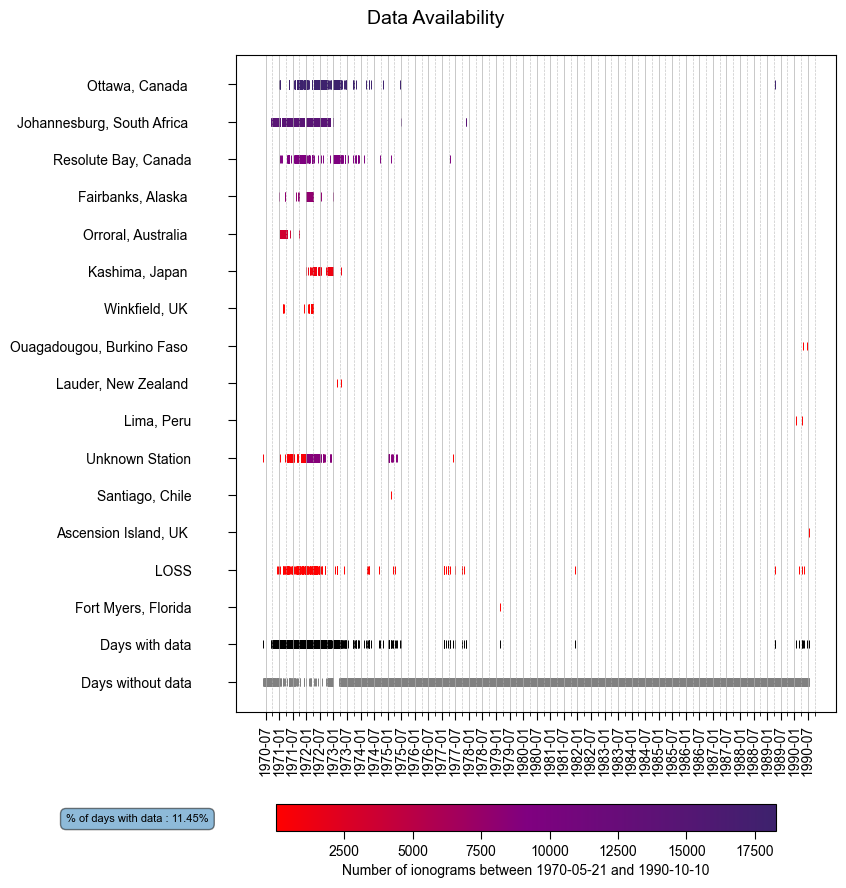

In [8]:
availabilityPlot(results_file = results_file, startDate = "19700521",endDate = "19901010",title = "Data Availability", 
                 stationCode ='all',cmap=redpurple)